<font size=5> Group06: Genin Victor, Raskin Florent, Rimez Dany

<font size=5  color=#003366> **[LGBIO2050] - Medical Imaging <br><br> 
Non-Rigid Image Registration ** </font> <br><br><br>

<font size=5  color=#003366>
Prof. G. Kerckhofs <br>
Prof. J. Lee <br>
Prof. B. Macq <br>
Prof. F. Peeters
<br><br>
Anne-Sophie Collin (anne-sophie.collin@uclouvain.be)<br> 
Damien Dasnoy-Sumell (damien.dasnoy@uclouvain.be) <br>
<div style="text-align: right"> 2020-2021 </div>
<br><br>
</font>

<font size=6 color=#009999> **1. Guidelines and Deliverables ** </font> <br> <br>
   - This assignment is due on **The 25th November 2020**.
   - Copying code or answers from other groups (or from the internet) is strictly forbidden. Each source of inspiration must be clearly indicated.
   - The jupyter notebook containing the code and **detailed answers** to the questions must be delivered in an
archive (.zip folder) on Moodle. The answers have to be written in English.<br> <br>



<font size=6 color=#009999> **2. Context ** </font> <br> <br>


The purpose of this challenge is to implement basic medical image registration tools. Aim of image registration is to align a ’moving’ image on a ’fixed’ image by finding a spatial transformation mapping all pixels in the ’moving’ image to pixels in the ’fixed’ image. <br>
Methods used in order to register medical images can be: 

- **Inter- vs Intra- patient.** Inter-patient methods register images captured on multiple patients while intra-patient methods register images captured on the same patient.<br>
*In the context of this challenge, you will perform intra-patient image registration which is less sensitive to anatomical variations.* <br><br>

- **Mono vs Multi- modal.** In the case of mono-modal registration, both ’fixed’ and ’moving’ images are of the same modality (MRI, PET, X-Rays,...). In the case of multi-modal registration, ’fixed’ and ’moving’ images are of different modalities (MRI/PET, PET/X-Rays,...). This second type of registration is useful to overlap different kind of information.<br>
*In the context of this challenge, you will perform mono-modal image registration on CT-scans.*<br><br>

- **Rigid vs non-rigid.** Rigid registration methods use a simple transform, uniformly applied over the entire image (like rotations or translations). In contrast, non-rigid registration methods allow to handle situations where the images to be registered have geometric differences that cannot be accounted by similarity (global translation, rotation, and scaling) transformations. In these cases, small variations in the images are taken into account in order to modify locally the deformation transform.<br>
*In the context of this challenge, you will implement a non-rigid image registration tool.*<br>


<div class="alert alert-info">
<b>QUESTION 1</b>  <br>
In the following cell, import the images named <samp>CT_lung_planning.png</samp> and <samp>CT_lung_during_treatment.png</samp>. Besides, import also the binary mask in <samp>Tumor_segmentation_for_planning.png</samp> file that gives the tumor's contour. Provide a preliminary visuallion of the problem by using the provided <samp>show_2images_and_difference</samp> function.  <br>

It is easy to see that these two images are not aligned. The purpose here is to automatically find the contour of the tumor on the intra-fraction image in order to assess the validity of the dose planning (i.e., by checking if the tumor is still entirely covered by the radiation beams). Thus, can you explain why registration is necessary in this context? Will the tumor be covered by the beam if its position is determined by the treatment planning? (15-20 lines).
</div>

**Answer to question 1:**

Here we clearly see that the tumor moves when the patient breathes. This causes the tumor to move out of the region where the radiation beams would be concentered: the area inside the contour of the tumor that appears in yellow on the figures. A first approach to this problem would be to enlarge the region hitten by the beams, so that the tumor will always be entirely hitten by them. But that means impaerement of more healthy tissues due to the radiation. The second approach is the to follow the displacements of the tumor during the treatment. This way, the beams will be able to hit the most tumor parts as possible while limiting the proportion of hitten healthy tissues. This 'following' of the tumor can be achieved with registration methods.

Image registration is the task of finding a meaningful spatial transformation or mapping from one image to another. 
Registration is necesseray to ensure that the tumor will always be covered by the beam when the treatment occurs. Indeed, we can clearly see that the tumor of the patient is not at the same places on the fixed and moving images (deformations mainly due to breathing during therapy). The goal of the non-rigid registration is thus to find a mapping between these two images. This non-rigid transformation will follow a first rigid transformation  (rigid registration). Then using the Demons algorithm, a non-rigid registration method refine the results (both registration methods are detailed in section 3). To ensure that the tumor will always be hit by the beam, we have to compute dose planing which is based on the Clinical Target Volume which is itself based on the tumor segmentation. If the tumor segmentation is done properly, the tumor will always be convered by the beam (the segmentation is detailed in section 4).

In [1]:
from skimage.io import imread
from skimage.color import rgb2grey
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy import ndimage
 
""" -----------------------------------------------------------------------------------------
Given a mask of the tumor region, returns two lists of coordinates (in X and Y) of the contour
INPUT : 
    - binary mask (image)
oUTPUT :
    - list of X and Y coordinates of the contour
----------------------------------------------------------------------------------------- """ 

def mask_to_coor(mask): 
    contours = measure.find_contours(mask.astype(float), 0)
    X, Y     = [], []
    for i in range(0,len(contours[0])):
        X.append(int(contours[0][i][1]))
        Y.append(int(contours[0][i][0]))
    return X, Y

""" -----------------------------------------------------------------------------------------
Two image plot (fixed and moving) + difference (fixed-moving)
INPUT : 
    - fixed: fixed image
    - moving: moving image
    - (mask: binary mask of the tumor)
----------------------------------------------------------------------------------------- """ 

def show_2images_and_difference(fixed, moving, mask=None, title=''): 
    f    = plt.figure(figsize=(11,4))
    f.suptitle(title,fontsize=20)
    fig1 = f.add_subplot('131')
    fig1.set_title('Fixed image', fontsize=14)
    fig1.imshow(fixed, cmap = 'gray')
    if mask is not None:
        X, Y = mask_to_coor(mask)
        for index in range(0, len(X)):
            if index == (len(X)-1): 
                fig1.plot( (X[index],X[0]), (Y[index],Y[0]) ,'y', linewidth=0.5)
            else: 
                fig1.plot( (X[index],X[index+1]), (Y[index],Y[index+1]) ,'y', linewidth=0.5)
    fig1.axis('off')

    fig2 = f.add_subplot('132')
    fig2.set_title('Moving image', fontsize=14)
    fig2.imshow(moving, cmap = 'gray')
    if mask is not None:
        X, Y = mask_to_coor(mask)
        for index in range(0, len(X)):
            if index == (len(X)-1): 
                fig2.plot( (X[index],X[0]), (Y[index],Y[0]) ,'y', linewidth=0.5)
            else: 
                fig2.plot( (X[index],X[index+1]), (Y[index],Y[index+1]) ,'y', linewidth=0.5)
    fig2.axis('off')

    fig3 = f.add_subplot('133')
    fig3.set_title('Difference', fontsize=14)
    fig3.imshow(fixed-moving, cmap = 'gray')
    fig3.axis('off')
 
    plt.show()
    plt.close()
    


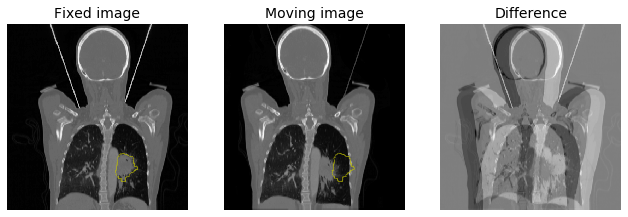

In [2]:
fixed = imread('imgs/CT_lung_planning.png',as_gray=True) 
moving = imread('imgs/CT_lung_during_treatment.png',as_gray=True) 
tumor = imread('imgs/Tumor_segmentation_for_planning.png',as_gray=True) 

show_2images_and_difference(fixed, moving, tumor)

<br> <br>
<font size=6 color=#009999> **3. Non-Rigid Registration ** </font> <br> <br>


<font size=5 color=#009999> *3.1 First... Ridig Registration!* </font>

Rigid registration is a way to transform images. Such modifications are simple transform uniformly applied on the entire image (rotations, translation, etc.). Those methods are not discussed in this challenge but they are crutial as preprocessing step before applying non-rigid registration. <br>
Execute the cell below to translate the moving image onto the fixed one. 

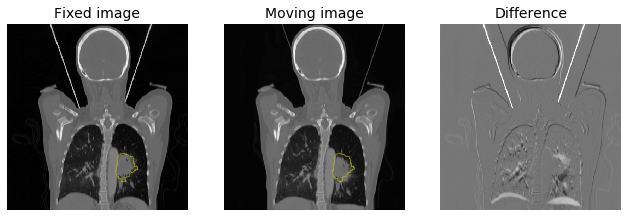

In [3]:
rows, cols  = fixed.shape[0], fixed.shape[1]
deformed    = ndimage.interpolation.affine_transform(moving, [[1,0],[0,1]], offset=[-1.98578807, -42.66788023], output_shape=(rows,cols))
show_2images_and_difference(fixed, deformed, mask=tumor)

<font size=5 color=#009999> *3.2 Demons * </font>

The next step consists in applying non-rigid registration on these images by deforming the pre-treatment image in order to get the best possible matching between images (this is mainly an estimation of deformations due to breathing). Unlike rigid registration methods, the demons algorithm allows to compute local transforms. This means that the mapping is no more defined by only two parameters but instead by a deformation field. This field is computed in every pixel based on local information (for instance the intensity and the gradient of the image). <br>

The demons method aims to approximately minimize the SSD as explained in [reference](https://pdfs.semanticscholar.org/29b2/4a6e4438993e5ec5fea139274a9570d430e3.pdf). The algorithm you will implement is a greedy algorithm composed of the following steps: <br> <br>

1.**Initialization**<br>
  - Define a deformed image as being equal to the moving image <br>
  - Initialize the accumulated deformation field <br>
  - Compute the gradient in the 'fixed' image  <font color=#cc3300> [Hint: use function gradient from numpy] </font> <br>
 
2.**Iterative process** <br>
 - Gradient descent step on the SSD criterion
     - Compute the gradient in the ’deformed’ image
     - Compute the update deformation field at each pixel with the demons equation:
 $$ \overrightarrow{\text{Field}} = \frac{-2 \times (D-F) \times \left(\overrightarrow{\nabla D} + \overrightarrow{\nabla F}\right) }{(D-F)^2 + \left(||\overrightarrow{\nabla D} + \overrightarrow{\nabla F}||\right)^2} $$ where $D$ is the value of the pixel in the deformed image, $F$ is the value of the pixel in the fixed image, $\overrightarrow{\nabla D}$ is the gradient of the deformed image and $\overrightarrow{\nabla F}$ is the gradient of the fixed image. 
    - Add the update deformation field to the accumulated field
 - Smoothing step
     - Regularize the field with a Gaussian smoothing performed by convoluting the two components of the field with a 2D Gaussian kernel. Try different variances to regularize your field and compare your results. <font color=#cc3300> [Hint: use function gaussian_filter from scipy.ndimage] </font> <br>
     - Calculate the new ’deformed’ image by interpolation
     - Compute the SSD metric


Remarks : 
- Note that the <samp>show_2images_and_field</samp> function allows you to visualize the deformation field. 
- In order to deform the moving image, you will have to give to each pixel $(x, y)$ the value in the moving image
located at $(x_d, y_d ) = (x, y) + d(x, y)$, where $d(x, y)$ is the deformation vector at pixel $(x, y)$. If $(x_d , y_d )$ does not correspond to the coordinate of a pixel, you will have to interpolate the value between surrounding pixels. <font color=#cc3300> [Hint: use function LinearNDInterpolator from scipy.interpolate with meshgrid from numpy] </font> <br>

<div class="alert alert-info">
<b>QUESTION 2</b>  <br>
Apply non-rigid registration on these images by deforming the intra-fraction image in order to get the best possible matching between images (this is mainly an estimation of deformations due to breathing). Does the SSD value decrease? (5-10 lines).
</div>

**Answer to question 2:**

To see if the SSD (computed as in [reference](https://pdfs.semanticscholar.org/29b2/4a6e4438993e5ec5fea139274a9570d430e3.pdf)) value decreases, we computed the first SSD value obtained using the after a rigid registration: 763.6892724319271. We then decided to add two paramters to the *registration* function so that we could define a minimum tolerence level for the SSD as well as a number of maximum iterations. By doing so, we obtained the SSD value of 359.9867157830931 after 71 iterations by setting a tolerance of 360. This implies that the SSD value decreases as the number of iterations increases. We thus get a better matching between the two images as number of iteration increases. However, once the algorithm converged to the image with the lowest SSD it can get with the least iterations, the next iterations degraded the image while keeping the SSD around the same value.

In [4]:
""" -----------------------------------------------------------------------------------------
Two image plot (fixed and moving) + deformation field
INPUT : 
    - fixed: fixed image
    - moving: moving image
    - field_x, field_y : deformation field in x and y coordinates
----------------------------------------------------------------------------------------- """ 

def show_2images_and_field(fixed, moving, field_x, field_y,s=50): 
    f    = plt.figure(figsize=(9,3))
    fig1 = f.add_subplot('131')
    fig1.set_title('Fixed image', fontsize=14)
    fig1.imshow(fixed, cmap = 'gray', interpolation = 'bicubic')
    fig1.axis('off')

    fig2 = f.add_subplot('132')
    fig2.set_title('Moving image', fontsize=14)
    fig2.imshow(moving, cmap = 'gray', interpolation = 'bicubic')
    fig2.axis('off')

    fig3           = f.add_subplot('133')
    rows, cols     = fixed.shape[0], fixed.shape[1]
    nx             = np.linspace(0, cols-1, cols)
    ny             = np.linspace(0, rows-1, rows)
    mesh_x, mesh_y = np.meshgrid(nx, ny) 
    field_y        = field_y[::-1]
    q = fig3.quiver(mesh_x[::20, ::20], mesh_y[::20, ::20], field_x[::20, ::20], field_y[::20, ::20], scale=s)
    fig3.axis('equal')
    fig3.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()
    
    
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator 

 Number of iterations: 70
 SSD: 359.1485481701488

SSD: 5632.573917723954


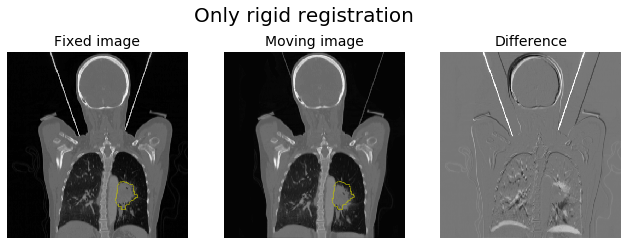


SSD: 763.6892724319271


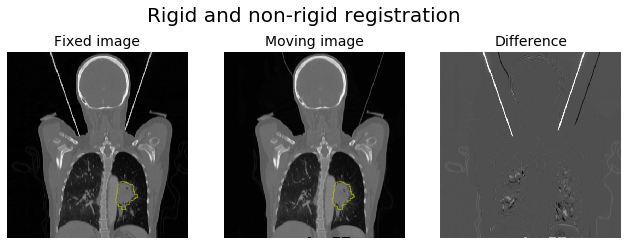



 Number of iterations: 300
 SSD: 361.914542873022


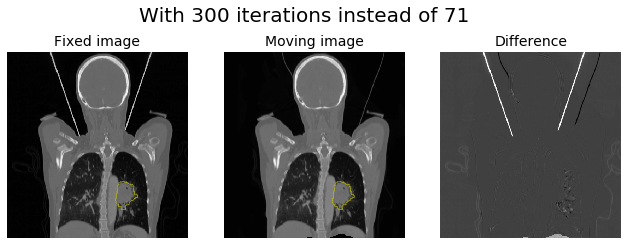

In [5]:
def registration(fixed, moving,sigmax,sigmay, tol=360, maxiter=300):

    deformed = np.copy(moving)
    f_grad = np.array(np.gradient(fixed))  
    g,h = deformed.shape
    field = np.zeros((2,g,h))   
    
    # initialisation of the interpolator
    x = np.arange(g)
    y = np.arange(h) 
    mesh = np.ones((g*h,2)) 
    for i in range(g):
        for j in range(h):
            mesh[h*i+j] = (i,j) 

    interpolator = LinearNDInterpolator(mesh,moving.flatten(),fill_value=0)    
    new_mesh = np.copy(mesh)
    
    it = 0 ; SSD = tol 
    while it<maxiter and SSD>=tol:
 
        # update the deformation
        d_grad = np.array(np.gradient(deformed))
        diff = deformed - fixed
        sum = d_grad + f_grad 
        denum = (diff**2) + (sum[0]**2) + (sum[1]**2)
        nonzero = denum!=0
        field[:,nonzero] += -2*diff[nonzero]*sum[:,nonzero]/denum[nonzero]  
          
        # smoothing step
        field[0] = gaussian_filter(field[0],(sigmax,sigmay))
        field[1] = gaussian_filter(field[1],(sigmax,sigmay))
         
        # deformation step    
        new_mesh[:,0] = mesh[:,0] + field[0].flatten()[:] 
        new_mesh[:,1] = mesh[:,1] + field[1].flatten()[:] 
        
        deformed = np.reshape(interpolator(new_mesh), deformed.shape)
              
        # SSD computation 
        SSD = np.sum((deformed-fixed)**2)

        it+=1 
        
    print(' Number of iterations: '+str(it)+'\n SSD: '+str(SSD))
    return deformed, field[0], field[1] 

Deformed,_,_ = registration(fixed, deformed,2,2)

SSD = np.sum((moving-fixed)**2)
print('\n'+'SSD: '+str(SSD)) 
show_2images_and_difference(fixed, deformed, mask=tumor, title='Only rigid registration') 
SSD = np.sum((deformed-fixed)**2)
print('\n'+'SSD: '+str(SSD)) 
show_2images_and_difference(fixed, Deformed, mask=tumor, title='Rigid and non-rigid registration') 
print('\n')   

Deformed,_,_ = registration(fixed, deformed,2,2,tol = 0)
show_2images_and_difference(fixed, Deformed, mask=tumor, title='With 300 iterations instead of 71')  

<div class="alert alert-info">
<b>QUESTION 3</b>  <br>
Which value of the variances (Gaussian kernel) seems to give the best result? Analyze the impact of a small/large value. Intuitively, does it make sense? (15-20 lines).
</div>

**Answer to question 3:**

To analyse the influence of the variances of the Gaussian kernel, we decided to compute the results using three different pairs of values (one value for the variance along the x-axis and another for the variance along the y-axis). 

The first pair of variance values tested was (1,1) as presented on the two first rows of the plots.  The value of SSD, 357.75492820877656 (obtained after 53 iterations), is a good improvement compared to the starting SSD value of 763.6892724319271 but the deformation vector field looks very irregular. We can also spot some irregularities and local defects on the output image. these irregularities implies that using these values of variances could lead to a beam that correctly follows the tumor most of the time, and sometimes hit a spot of healthy tissues too or miss a spot belonging to the tumor.

The second pair of variance values we tested was (2,2) as presented on the third and fourth rows of the plots. The value of SSD obtained after 71 iterations, 359.9867157830931, is also a good imporvement compared to the starting SSD value of 763.6892724319271 and the deformation field looks more regular. The output image also seems to have less defects. Thus, the better quality of the outputs comes at the cost of more iterations. 

The third pair of variance values we tested was (4,4) as presented on the fifth and sixth rows of the plots. The value of SSD obtained after 300 iterations, 452.4920815370128 (the maximum iteration value was reached), is not as good of an imporvement compared to the other SSD values obtained with the (1,1) and (2,2) pair values of variances. However, the deformation field looks more regular and smoother. The output image also seems to have less local defects. We observe that the SSD value is not optimal for high variances values. 

We can also deduce that increasing the variances will increase the blurring effect of the gaussian filter on the deformation field, reducing local irregularities and leading to a more uniform field which will then present more distributed irregularities. This spreading of irregularities causes a sort of "mean error" across the image that impedes convergence of the demons algorithm (depending on the value of the variances) which leads to higher SSD values and apparition of some defects as the dark area below the left lung of the patient. We can see that phenomenon on the images obtained with (4,4). Hence, the more we will increase the variances, the more the mean error will be incresed and the more we will have to enlarge the region hitten by the beam.

In conclusion, we must find a compromise between a regular and smooth output image with more spreaded errors (with higher SSD and higher iterations), and an image with lower SSD and number of iterations but more local defects. We thus decide to set the pair of values at (2,2) for which we obtain the best compromise results in order to correctly follow the tumor while having less local and mean errors as possible. 

Start SSD: 763.6892724319271

 Number of iterations: 53
 SSD: 357.75492820877656


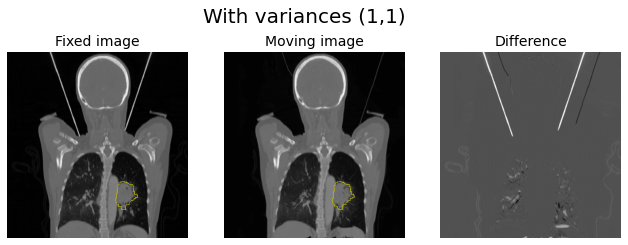

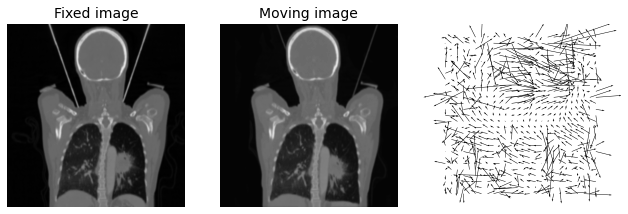



 Number of iterations: 71
 SSD: 359.9867157830931


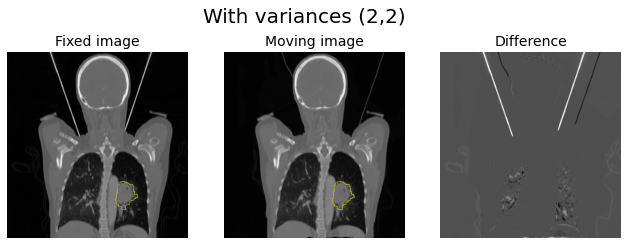

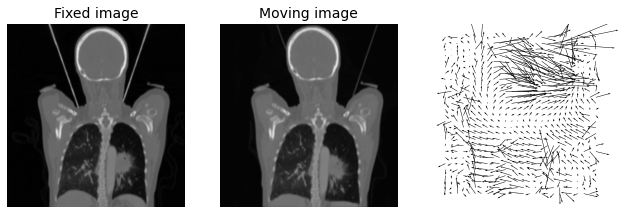



 Number of iterations: 300
 SSD: 452.4920815370128


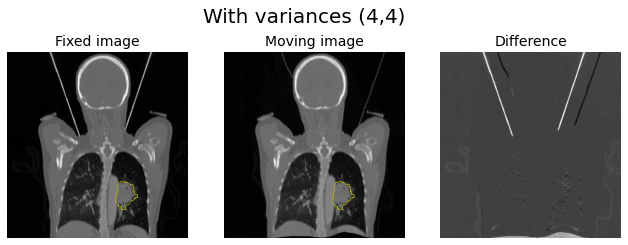

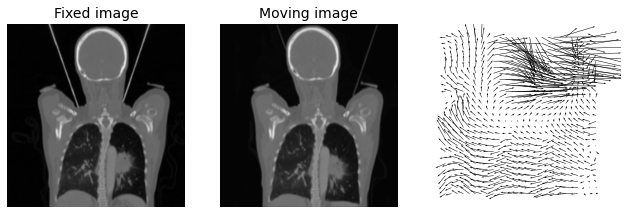

In [ ]:
SSD = np.sum((deformed-fixed)**2)
print('Start SSD: '+str(SSD)+'\n') 
Deformed, field_x, field_y = registration(fixed, deformed,1,1) 
show_2images_and_difference(fixed, Deformed, mask=tumor,title='With variances (1,1)') 
show_2images_and_field(fixed, deformed, field_x, field_y)
print('\n')
Deformed, field_x, field_y = registration(fixed, deformed,2,2) 
show_2images_and_difference(fixed, Deformed, mask=tumor,title='With variances (2,2)') 
show_2images_and_field(fixed, deformed, field_x, field_y)
print('\n')
Deformed, field_x, field_y = registration(fixed, deformed,4,4)
show_2images_and_difference(fixed, Deformed, mask=tumor,title='With variances (4,4)')  
show_2images_and_field(fixed, deformed, field_x, field_y)

<div class="alert alert-info">
 
<b>QUESTION 4</b>  <br>
Also, try to apply the demons on the original images (with no rigid registration) and comment your results. Is the final result different? Why? (10-15 lines).
</div>

**Answer to question 4:**
Here we have made two observations. First, we see in the cell hereunder that for the same variances as before (2,2), we have a lot more iterations to do to have a comparable result (2205 instead of 71). However, we see a defect on the output image, near the spine on the right lung. We attributed this defect to the accumulation of local errors at each iterations. Indeed, even if the smoothing step of the algorithm reduces them, it does not discard them entirely. We can also point out that the deformation field seems to be nice at first side, but as we just said, it must have local defects that would explain why a part of the spine was not translated as the rest of the image and was even spread into the lung.

Secondly, on the next cell we plotted the results obtained with variances (1,1). When we used these values of variances with the image modified with rigid registration, we had more local errors but less iterations for a similar performance. However these values of variances used on the image without rigid registration led to an awful result. We can clearly see that there is a lot of errors in the output image, even after 5000 iterations, while we had only 2205 iterations for a better result. That is why we think that not only too high values of variances reduce the efficiency of the Demons algorithm, but also too low ones. Here the fact that the algorithm did not converge to a good solution could be attributed to the local deffects appearing with lower variances. Those errors would sum up, iterations after iterations, and lead to big local deffects you can see on the output.

The last cell of the section shows the resluts with the (4,4) variances. We can see that the deformation field is smoother and that the SSD was near to the one obtained with (2,2). However, it took 5000 iterations, and the area below the lunngs was also deformed by the algorithm. But here the we don't have the local defect in the right lung, we thus have a better compromise with the (4,4) variances than with the (2,2) ones. Nevertheless, the better results were obtained with the (3,3) variances, with the a similar output image than (4,4) but with the lowest iterations and SSD. 

Finally, we can highlight the fact that to obtain acceptable results, we have to do thousands of iterations, which takes a lot of time (several minutes on our computers) and is not compatible with the purpose we want to use it for. Indeed, if the algorithm takes minutes to compute the wanted displacement of the beam, we would follow the tumor by saccades spaced by minutes and the beam would hit the location where the tumor was minutes ago, and as the beam will not move, we will have to increase the region it hits to spot the entire tumor everytime and not only when it passes in the location it was when we started the algorithm. Furthermore, even if computing the results would be done in an instant, we have seen that starting from the image without rigid registration produces more errors which could be dramatic for the following of the tumor if those errors occur near the tumor. 

Start SSD: 5632.573917723954

 Number of iterations: 2205
 SSD: 359.7288861165084


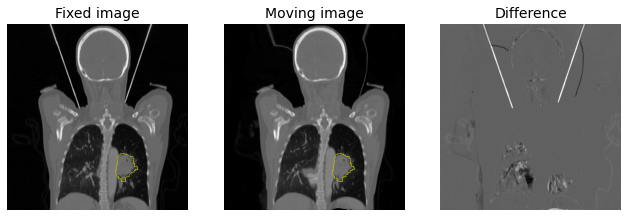

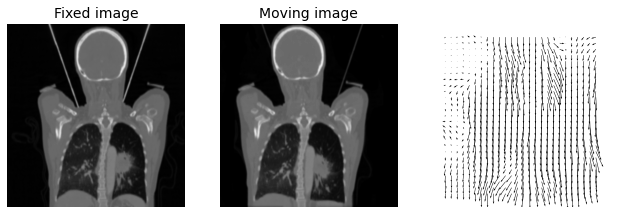

In [ ]:
SSD = np.sum((moving-fixed)**2)
print('Start SSD: '+str(SSD)+'\n')
Deformed, field_x, field_y = registration(fixed, moving,2,2,maxiter=5000)
show_2images_and_difference(fixed, Deformed, mask=tumor)   
show_2images_and_field(fixed, moving, field_x, field_y,s=600)

Start SSD: 5632.573917723954

 Number of iterations: 5000
 SSD: 940.2618606773939


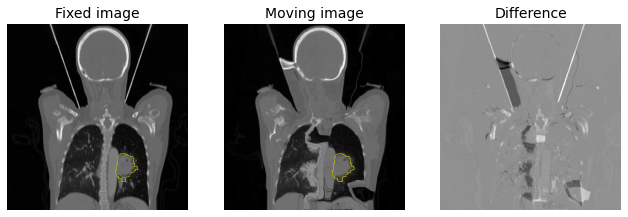

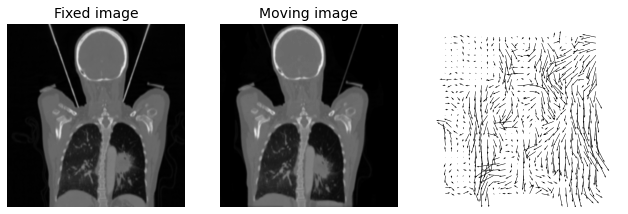

In [ ]:
SSD = np.sum((moving-fixed)**2)
print('Start SSD: '+str(SSD)+'\n')
Deformed, field_x, field_y = registration(fixed, moving,1,1,maxiter=5000) 
show_2images_and_difference(fixed, Deformed, mask=tumor) 
show_2images_and_field(fixed, moving, field_x, field_y,s=600) 

Start SSD: 5632.573917723954

 Number of iterations: 5000
 SSD: 391.3981188396654


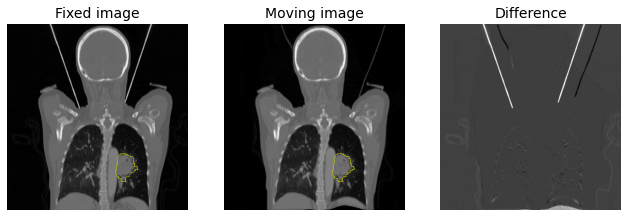

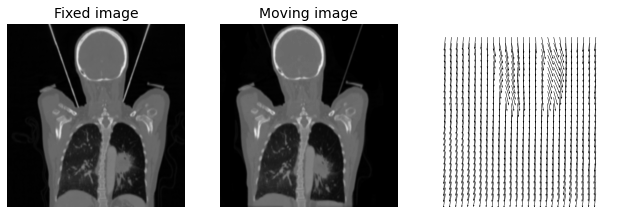

In [ ]:
SSD = np.sum((moving-fixed)**2)
print('Start SSD: '+str(SSD)+'\n')
Deformed, field_x, field_y = registration(fixed, moving,4,4,maxiter=5000) 
show_2images_and_difference(fixed, Deformed, mask=tumor) 
show_2images_and_field(fixed, moving, field_x, field_y,s=600) 

Start SSD: 5632.573917723954

 Number of iterations: 1057
 SSD: 359.8967538111866


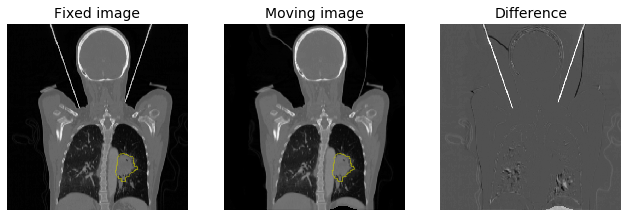

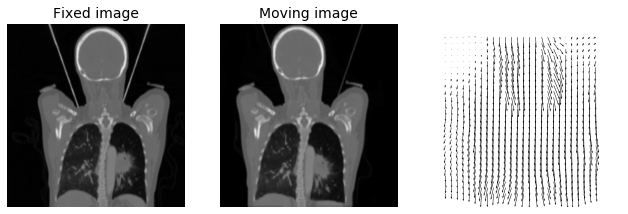

In [11]:
SSD = np.sum((moving-fixed)**2)
print('Start SSD: '+str(SSD)+'\n')
Deformed, field_x, field_y = registration(fixed, moving,3,3,maxiter=5000) 
show_2images_and_difference(fixed, Deformed, mask=tumor) 
show_2images_and_field(fixed, moving, field_x, field_y,s=600) 

<br> <br>
<font size=6 color=#009999> **4. Segmentation of the Clinical Target Volume (CTV) ** </font> <br> <br>

As the dose planning is based on the Clinical Target Volume (CTV), we have to compute this segmentation. The CTV is simply the tumor segmentation expanded with a 5 mm margin in every directions to take the suspected microscopic spread into account.

<div class="alert alert-info">
<b>QUESTION 5</b>  <br>
Use a morphological dilation in order to compute the CTV starting from the tumor segmentation. (The pixel spacing in the provided images is equal to 1mm).
</div>

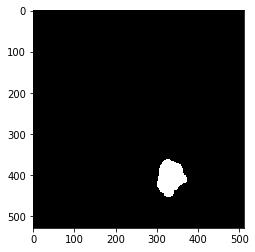

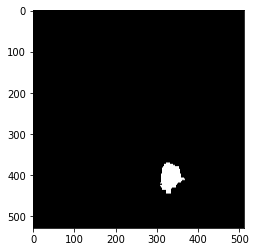

In [7]:
g,h = fixed.shape
element = lambda x,y: np.array([[1 if (i-y)**2 + (j-x)**2 <= 25 else 0 for j in range(h)] for i in range(g)])

binary = np.zeros_like(fixed)
X,Y = mask_to_coor(tumor)
for x,y in zip(X,Y): 
    binary += element(x,y) 
binary += tumor.astype(np.float64) 
binary /= np.max(binary)
binary = np.ceil(binary) 
plt.imshow(binary,cmap='gray')
plt.show()
plt.imshow(tumor,cmap='gray')
plt.show() 